# Alignment of two Xenium Replicates and one Visium section



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 0. Setup

### Import libraries

In [3]:
import os
from shapely.geometry import Polygon
os.environ['USE_PYGEOS'] = '0'
import geopandas
import shutil
import numpy as np
import napari
import os
import squidpy as sq                                            
import scanpy as sc
import pandas as pd
import anndata 
import spatialdata as sd
from spatialdata.transformations import Affine, Sequence, Identity, align_elements_using_landmarks, get_transformation, set_transformation
from napari_spatialdata import Interactive

### Paths

In [4]:
print('current working directory:', os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(SPATIALDATA_SANDBOX_PATH), f'{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available'
GENERATED_DATA_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, 'generated_data/xenium_visium_integration')
assert os.path.isdir(GENERATED_DATA_PATH), f'{GENERATED_DATA_PATH} not found, please use symlinks to make it available'

 # this file is available on the shared google drive folder
BC_SC_ATLAS_PATH     = os.path.join(GENERATED_DATA_PATH, "BC_atlas_xe.h5ad")

# 1. run spatialdata-sandbox/xenium_rep1_io/download.py
# 2. run spatialdata-sandbox/xenium_rep1_io/to_zarr.py to get the zarr files 
XE_REP1_PATH         = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr") 
# this the output path for xe_rep1
XE_REP1_ROI_PATH     = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")
# 1. run spatialdata-sandbox/xenium_rep2_io/download.py
# 2. run spatialdata-sandbox/xenium_rep2_io/to_zarr.py to get the zarr files 
XE_REP2_PATH         = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")
# this the output path for xe_rep2
XE_REP2_ROI_PATH     = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")
# 1. run spatialdata-sandbox/visium_associated_xenium_io/download.py
# 2. run spatialdata-sandbox/visium_associated_xenium_io/to_zarr.py to get the zarr files 
VISIUM_PATH          = os.path.join(SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr")
# this the output path for visium
VISIUM_ROI_PATH      = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")
# this file is provided in the shared google drive folder
LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

paths = [BC_SC_ATLAS_PATH, XE_REP1_PATH, XE_REP2_PATH, VISIUM_PATH, LANDMARKS_SDATA_PATH]
for path in paths:
    assert os.path.exists(path), f'{path} not found'

current working directory: /Users/macbook/embl/projects/basel/spatialdata-sandbox/notebooks


### Load data

In [5]:
def annotate_bc_xe(bc_sc_atlas_adata, adata_query):
    # adata_query = xe_rep1_adata
    genes = list(set(bc_sc_atlas_adata.var_names) & set(adata_query.var_names))
    bc_sc_atlas_adata = bc_sc_atlas_adata[:, genes]
    adata_query       = adata_query[:, genes]
    sc.pp.normalize_total(adata_query, target_sum=1e4)
    sc.pp.log1p(adata_query)


    sc.pp.pca(bc_sc_atlas_adata)
    sc.pp.neighbors(bc_sc_atlas_adata)
    sc.tl.umap(bc_sc_atlas_adata)
    sc.tl.ingest(adata_query, bc_sc_atlas_adata, obs='celltype_major')


    ad = {}
    for t in adata_query.obs['celltype_major'].unique():
        query_sub = adata_query[adata_query.obs['celltype_major']==t]
        ref_sub = bc_sc_atlas_adata[bc_sc_atlas_adata.obs['celltype_major']==t]
        sc.pp.pca(ref_sub)
        sc.pp.neighbors(ref_sub)
        sc.tl.umap(ref_sub)
        sc.tl.ingest(query_sub, ref_sub, obs='celltype_minor', inplace=True)
        ad[t] = query_sub

    adata_query = anndata.concat(ad)
    return adata_query

In [6]:
bc_sc_atlas_adata = sc.read(BC_SC_ATLAS_PATH)
bc_sc_atlas_adata.obs['dataset'] = 'atlas'

xe_rep1_sdata     = sd.read_zarr(XE_REP1_PATH)
xe_rep1_adata     = xe_rep1_sdata.table
xe_rep1_adata.obs['dataset'] = 'xe_rep1'

xe_rep2_sdata     = sd.read_zarr(XE_REP2_PATH)
xe_rep2_adata     = xe_rep2_sdata.table
xe_rep2_adata.obs['dataset'] = 'xe_rep2'

visium_sdata      = sd.read_zarr(VISIUM_PATH)
visium_adata      = visium_sdata.table
visium_adata.obs['dataset'] = 'visium'

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


In [7]:
xe_rep1_sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': 

In [8]:
xe_rep2_sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25779, 35411), (1, 12889, 17705), (1, 6444, 8852), (1, 3222, 4426), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25779, 35411), (1, 12889, 17705), (1, 6444, 8852), (1, 3222, 4426), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (31997227, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (118752, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (118752, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (118752, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 118752 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': 

In [9]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Hu

In [10]:
%%time

CELL_TYPES_ALREADY_TRANSFERRED = True
if not CELL_TYPES_ALREADY_TRANSFERRED:
    # this takes a while, go for a walk!
    xe_rep1_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep1_adata)
    xe_rep2_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep2_adata)
    xe_rep1_annotated.write(os.path.join(GENERATED_DATA_PATH, 'xe_rep1_annotated.h5ad'))
    xe_rep2_annotated.write(os.path.join(GENERATED_DATA_PATH, 'xe_rep2_annotated.h5ad'))
else:
    xe_rep1_annotated = sc.read(os.path.join(GENERATED_DATA_PATH, 'xe_rep1_annotated.h5ad'))
    xe_rep2_annotated = sc.read(os.path.join(GENERATED_DATA_PATH, 'xe_rep2_annotated.h5ad'))

CPU times: user 180 ms, sys: 88.2 ms, total: 268 ms
Wall time: 288 ms


In [11]:
xe_rep1_sdata.table.obs[['celltype_major', 'celltype_minor']] = xe_rep1_annotated.obs[['celltype_major', 'celltype_minor']]
xe_rep2_sdata.table.obs[['celltype_major', 'celltype_minor']] = xe_rep2_annotated.obs[['celltype_major', 'celltype_minor']]

## 1. Process 

### 1.1 Alignment using 3 landmarks points

We take `xe_rep1` as the reference section and align the other two to it. The new coordinate systems is called `aligned`.

In [12]:
xenium_subset = sd.SpatialData(
    images={
        "xe_rep1": xe_rep1_sdata.images["morphology_mip"],
        "xe_rep2": xe_rep2_sdata.images["morphology_mip"],
        "visium" : visium_sdata.images['CytAssist_FFPE_Human_Breast_Cancer_full_image']
    }
)

In [13]:
ALREADY_IN_ZARR = True
overwrite = False
if ALREADY_IN_ZARR and not overwrite:
    landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)
else:
    # annotations are provided. If you want to recreated call napari and then save the annotations
    # you have to obtain an object that looks like this
    # SpatialData object with:
    # └── Shapes
    #       ├── 'box': GeoDataFrame shape: (1, 1) (2D shapes)
    #       ├── 'visium_lm': GeoDataFrame shape: (3, 2) (2D shapes)
    #       ├── 'xe_rep1_lm': GeoDataFrame shape: (3, 2) (2D shapes)
    #       └── 'xe_rep2_lm': GeoDataFrame shape: (3, 2) (2D shapes)
    # with coordinate systems:
    # ▸ 'global', with elements:
    #         box (Shapes), visium_lm (Shapes), xe_rep1_lm (Shapes), xe_rep2_lm (Shapes)
    landmarks_sdata = sd.SpatialData(shapes=xenium_subset.shapes)
    landmarks_sdata.write(LANDMARKS_SDATA_PATH, overwrite=overwrite)
    
landmarks_sdata

SpatialData object with:
└── Shapes
      ├── 'box': GeoDataFrame shape: (1, 1) (2D shapes)
      ├── 'visium_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      ├── 'xe_rep1_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      └── 'xe_rep2_lm': GeoDataFrame shape: (3, 2) (2D shapes)
with coordinate systems:
▸ 'global', with elements:
        box (Shapes), visium_lm (Shapes), xe_rep1_lm (Shapes), xe_rep2_lm (Shapes)

In [14]:
# this creates the 'aligned` coordinate system, maps the moving (xenium rep 2) and reference elements (xenium rep 1) to that system
affine_rep2_to_rep1 = align_elements_using_landmarks(
    references_coords = landmarks_sdata.shapes['xe_rep1_lm'],
    moving_coords     = landmarks_sdata.shapes['xe_rep2_lm'],
    reference_element = xenium_subset.images['xe_rep1'],
    moving_element    = xenium_subset.images['xe_rep2'],
    reference_coordinate_system = 'global',
    moving_coordinate_system    = 'global',
    new_coordinate_system       = 'aligned'
)

In [15]:
# same as above. Now the moving element is visium and the reference element is again xenium rep 1
affine_visium_to_rep1 = align_elements_using_landmarks(
    references_coords = landmarks_sdata.shapes['xe_rep1_lm'],
    moving_coords     = landmarks_sdata.shapes['visium_lm'],
    reference_element = xenium_subset.images['xe_rep1'],
    moving_element    = xenium_subset.images['visium'],
    reference_coordinate_system = 'global',
    moving_coordinate_system    = 'global',
    new_coordinate_system       = 'aligned'
)

## 1.2. Transforming transcripts for the xenium replicates

For each element of xenium rep 1, xenium rep 2 and of visium, let's add a transformation to the coordinate system `'aligned'`. This instruct the framework how to map each element to the `'aligned'` coordinate system.

This part of the code will be simplified and become more ergonomic after the new coordinate systems refactoring.

In [16]:
# we use an identity for xenium rep 1 since we use it as a reference
from spatialdata import SpatialData
from spatialdata.transformations import BaseTransformation

def postpone_transformation(sdata: SpatialData, transformation: BaseTransformation, source_coordinate_system: str, target_coordinate_system: str):
    for element_type, element_name, element in sdata._gen_elements():
        old_transformations = get_transformation(element, get_all=True)
        if source_coordinate_system in old_transformations:
            old_transformation = old_transformations[source_coordinate_system]
            sequence = Sequence([old_transformation, transformation])
            set_transformation(element, sequence, target_coordinate_system)
        
postpone_transformation(sdata=xe_rep1_sdata, transformation=Identity(), source_coordinate_system='global', target_coordinate_system='aligned')
postpone_transformation(sdata=xe_rep2_sdata, transformation=affine_rep2_to_rep1, source_coordinate_system='global', target_coordinate_system='aligned')
postpone_transformation(sdata=visium_sdata, transformation=affine_visium_to_rep1, source_coordinate_system='global', target_coordinate_system='aligned')

## 1.3. Transforming cells and spots


In [17]:
xe_rep1_sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': 

In [18]:
# let's create a copy of the spatialdata objects and transform the data (as opposed to just set the transformation as done above)

xe_rep1_transformed_sdata = sd.SpatialData(
    shapes=xe_rep1_sdata.shapes,
    points=xe_rep1_sdata.points,
    table=xe_rep1_sdata.table
)

xe_rep2_transformed_sdata = sd.SpatialData(
    shapes=xe_rep2_sdata.shapes,
    points=xe_rep2_sdata.points,
    table=xe_rep2_sdata.table
)

visium_transformed_sdata = sd.SpatialData(
    shapes=visium_sdata.shapes,
    points=visium_sdata.points,
    table=visium_sdata.table
)

xe_rep1_transformed_sdata = xe_rep1_transformed_sdata.transform_to_coordinate_system('aligned')
xe_rep2_transformed_sdata = xe_rep2_transformed_sdata.transform_to_coordinate_system('aligned')
visium_transformed_sdata = visium_transformed_sdata.transform_to_coordinate_system('aligned')

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


## 1.4. Find the shared area between three datasets
This is a trick that we used to work around napari polygon selections. We take the intersection of the convex hulls of the transformed (aligned) cells/spots in order to find the shared area. This could be simply done by a napari selection, but I couldn't do this on my machine. 

We don't execute the following cells because the convec hull approach is computational expensive and we already have the handrawn annotation of the interection area.

In [19]:
from geopandas import GeoSeries

def get_extent(geoseries: GeoSeries):
    min_x, min_y = np.min(geoseries.bounds.iloc[:, :2], axis=0)
    max_x, max_y = np.max(geoseries.bounds.iloc[:, 2:], axis=0)
    print(f'min_x = {min_x}, min_y = {min_y}, max_x = {max_x}, max_y = {max_y}')

min_x = 22.818372969907816, min_y = 1782.3875133821296, max_x = 7264.954081389041, max_y = 5493.863106395877
min_x = 107.38057868191913, min_y = 8387.705945327669, max_x = 34188.019206536665, max_y = 25853.473441862952
min_x = 10.035369873046873, min_y = 6.43367338180542, max_x = 35402.76171875, max_y = 25770.6640625
min_x = -1890.9218211108787, min_y = 8341.370145984734, max_x = 34275.51643331356, max_y = 34900.47301788409


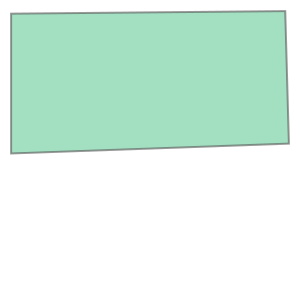

In [20]:
# the transformation of 'box' is wrong, let's fix it manually
t = get_transformation(xe_rep1_sdata.shapes['cell_circles'], 'global')
pp = landmarks_sdata.shapes['box']
transformed_pp = sd.transform(pp, t)
get_extent(pp)
get_extent(transformed_pp)
get_extent(xe_rep1_transformed_sdata.shapes['cell_circles'])
get_extent(xe_rep2_transformed_sdata.shapes['cell_circles'])
transformed_pp = transformed_pp.geometry.iloc[0]
transformed_pp

The functions below implement spatial queries operations on polygons. These functions will be implemented in SpatialData and the code will become simpler.

In [21]:
from dask.dataframe.core import DataFrame as DaskDataFrame
from geopandas import GeoDataFrame

def points_dask_dataframe_to_geopandas(points: DaskDataFrame) -> GeoDataFrame:
    # let's ignore the z component here
    points_gdf = GeoDataFrame(
        geometry=geopandas.points_from_xy(points['x'], points['y'])
    )
    for c in points.columns:
        points_gdf[c] = points[c]
    return points_gdf

def points_geopandas_to_dask_dataframe(gdf: GeoDataFrame) -> DaskDataFrame:
    # convert the GeoDataFrame to a Dask DataFrame
    ddf = dd.from_pandas(gdf[gdf.columns.drop('geometry')], npartitions=1)
    ddf['x'] = gdf.geometry.x
    ddf['y'] = gdf.geometry.y
    # parse
    ddf = PointsModel.parse(ddf, coordinates={'x': 'x', 'y': 'y'}) 
    return ddf

In [22]:
%%time
from shapely import Polygon
from spatialdata.models import ShapesModel, PointsModel
from dask.dataframe.core import DataFrame as DaskDataFrame
import dask.dataframe as dd

# this takes a while, take a nap!
def spatial_query_shapes_and_points_by_polygon(sdata: SpatialData, polygon: Polygon, target_coordinate_system: str):
    new_shapes = {}
    for shapes_name, shapes in sdata.shapes.items():
        if '__old_index' in shapes.columns:
            assert np.all(shapes['__old_index'] == shapes.index)
        else:
            shapes['__old_index'] = shapes.index
        # indices = shapes.intersects(polygon)
        # indices = shapes.geometry.apply(lambda x: x.intersects(polygon).values.tolist()[0][0])
        indices = shapes.geometry.apply(lambda x: x.intersects(polygon))
        if np.sum(indices) == 0:
            raise ValueError('we expect at least one shape')
        queried_shapes = shapes[indices]
        queried_shapes.index = queried_shapes['__old_index']
        del shapes['__old_index']
        del queried_shapes['__old_index']
        transformation = get_transformation(shapes, target_coordinate_system)
        queried_shapes = ShapesModel.parse(queried_shapes)
        set_transformation(queried_shapes, transformation, target_coordinate_system)
        new_shapes[shapes_name] = queried_shapes

    new_points = {}
    for points_name, points in sdata.points.items():
        # let's ignore the z component here
        points_gdf = points_dask_dataframe_to_geopandas(points)
        # queried_points = points_gdf.intersects(pp)
        indices = points_gdf.geometry.intersects(polygon)
        if np.sum(indices) == 0:
            raise ValueError('we expect at least one point')
        queried_points = points_gdf[indices]
        ddf = points_geopandas_to_dask_dataframe(queried_points)
        new_points[points_name] = ddf
        
    return SpatialData(shapes=new_shapes, points=new_points, table=sdata.table)

CPU times: user 21 µs, sys: 1e+03 ns, total: 22 µs
Wall time: 23.6 µs


In [23]:
%%time
# let's keep only the shapes inside the query polygon (roi)
# and then let's manually filter the table to keep only the rows that are inside the polygon pp
xe_rep1_roi_sdata = spatial_query_shapes_and_points_by_polygon(sdata=xe_rep1_transformed_sdata, polygon=transformed_pp, target_coordinate_system='aligned')

CPU times: user 3min 59s, sys: 50.8 s, total: 4min 49s
Wall time: 3min 28s


In [24]:
merged = pd.merge(xe_rep1_roi_sdata.table.obs[['cell_id']], xe_rep1_roi_sdata.shapes['cell_circles'], how='right', left_on='cell_id', right_index=True)
filtered_table = xe_rep1_roi_sdata.table[merged.index].copy()
del xe_rep1_roi_sdata.table
xe_rep1_roi_sdata.table = filtered_table

In [25]:
%%time
xe_rep2_roi_sdata = spatial_query_shapes_and_points_by_polygon(sdata=xe_rep2_transformed_sdata, polygon=transformed_pp, target_coordinate_system='aligned')

CPU times: user 4min 5s, sys: 2min 34s, total: 6min 40s
Wall time: 3min 47s


In [26]:
merged = pd.merge(xe_rep2_roi_sdata.table.obs[['cell_id']], xe_rep2_roi_sdata.shapes['cell_circles'], how='right', left_on='cell_id', right_index=True)
filtered_table = xe_rep2_roi_sdata.table[merged.index].copy()
del xe_rep2_roi_sdata.table
xe_rep2_roi_sdata.table = filtered_table

In [27]:
%%time
visium_roi_sdata = spatial_query_shapes_and_points_by_polygon(sdata=visium_transformed_sdata, polygon=transformed_pp, target_coordinate_system='aligned')

CPU times: user 55.5 ms, sys: 1.55 ms, total: 57 ms
Wall time: 58 ms


In [28]:
merged = pd.merge(visium_roi_sdata.table.obs[['spot_id']], visium_roi_sdata.shapes['CytAssist_FFPE_Human_Breast_Cancer'], how='right', left_on='spot_id', right_index=True)
filtered_table = visium_roi_sdata.table[visium_roi_sdata.shapes['CytAssist_FFPE_Human_Breast_Cancer'].index].copy()
del visium_roi_sdata.table
visium_roi_sdata.table = filtered_table

In [29]:
from copy import copy
sel_genes = list(set(visium_roi_sdata.table.var_names) & (set(xe_rep1_roi_sdata.table.var_names)))

filtered_table = xe_rep1_roi_sdata.table[:, sel_genes].copy()
del xe_rep1_roi_sdata.table
xe_rep1_roi_sdata.table = filtered_table

filtered_table = xe_rep2_roi_sdata.table[:, sel_genes].copy()
del xe_rep2_roi_sdata.table
xe_rep2_roi_sdata.table = filtered_table

filtered_table = visium_roi_sdata.table[:, sel_genes].copy()
del visium_roi_sdata.table
visium_roi_sdata.table = filtered_table

## 1.5. Cell-type interpolation of the visium spots


In [30]:
%%time
visium_spots_polygons = visium_roi_sdata.shapes['CytAssist_FFPE_Human_Breast_Cancer'].copy()
visium_spots_polygons['geometry'] = visium_spots_polygons.buffer(visium_spots_polygons.radius.iloc[0], 128)

visium_spots_polygons['spot_id'] = visium_spots_polygons.index
xe_rep1_roi_sdata.shapes['cell_boundaries']['cell_id'] = xe_rep1_roi_sdata.shapes['cell_boundaries'].index
xe_rep2_roi_sdata.shapes['cell_boundaries']['cell_id'] = xe_rep2_roi_sdata.shapes['cell_boundaries'].index

spots_xe_rep1 = visium_spots_polygons.overlay(xe_rep1_roi_sdata.shapes['cell_boundaries'], how='intersection')
spots_xe_rep2 = visium_spots_polygons.overlay(xe_rep2_roi_sdata.shapes['cell_boundaries'], how='intersection')

CPU times: user 10.3 s, sys: 184 ms, total: 10.5 s
Wall time: 10.6 s


In [31]:
from geopandas import GeoDataFrame
from typing import Any

def get_geoseries_types(gdf: GeoDataFrame) -> set[Any]:
    types = set()
    geom = gdf.geometry
    for i in range(len(geom)):
        x = geom.iloc[i]
        types.add(type(x))
    return types

In [32]:
# as you can see from here:
print(len(spots_xe_rep1.cell_id.unique()))
print(len(spots_xe_rep1))
# there are some rows that refer to the same cell.

62030
62179


In [33]:
# Also, some rows are Polygons, others are Multipolygons
print(get_geoseries_types(xe_rep1_roi_sdata.shapes['cell_boundaries']))
print(get_geoseries_types(visium_spots_polygons))
print(get_geoseries_types(spots_xe_rep1))

{<class 'shapely.geometry.polygon.Polygon'>}
{<class 'shapely.geometry.polygon.Polygon'>}
{<class 'shapely.geometry.multipolygon.MultiPolygon'>, <class 'shapely.geometry.polygon.Polygon'>}


In [34]:
# The first are cells that touch multiple Visium circles. The second are cells that intersect the same Visium circles in multiple points.

Each spot is deconvolved based on the intersected areas with the xenium cells. We do this for both repolicates and at the minor and major cell type levels. 

In [35]:
%%time
from sklearn.preprocessing import OneHotEncoder
spots_xe_rep1['area'] = spots_xe_rep1['geometry'].area
ss = spots_xe_rep1.pivot_table(index=["spot_id"], 
                    columns='cell_id', 
                    values='area', # add margins
                    aggfunc='sum').fillna(0)
ss = ss.div(ss.sum(axis=1), axis=0)
missing_spots = list(set(visium_spots_polygons['spot_id']).difference(set(ss.index)))
ms_df = pd.DataFrame([[0]*ss.shape[1]],columns=ss.columns, index=missing_spots)
ss = ss.append(ms_df)
ss = ss.loc[visium_roi_sdata.table.obs['spot_id']]

ohe       = OneHotEncoder()                                                                           
major_one = ohe.fit_transform(xe_rep1_sdata.table[list(ss.columns),:].obs[['celltype_major']])
spot_xe_rep1_types = ss.to_numpy() @ major_one 
visium_roi_sdata.table.copy().obsm['xe_rep1_celltype_major'] = spot_xe_rep1_types

ohe       = OneHotEncoder()                                                                           
minor_one = ohe.fit_transform(xe_rep1_sdata.table[list(ss.columns),:].obs[['celltype_minor']])
spot_xe_rep1_types = ss.to_numpy() @ minor_one 
visium_roi_sdata.table.obsm['xe_rep1_celltype_minor'] = spot_xe_rep1_types

CPU times: user 3.13 s, sys: 3.24 s, total: 6.38 s
Wall time: 6.91 s


In [36]:
%%time
spots_xe_rep2['area'] = spots_xe_rep2['geometry'].area
ss = spots_xe_rep2.pivot_table(index=["spot_id"], 
                    columns='cell_id', 
                    values='area', # add margins
                    aggfunc='sum').fillna(0)
ss = ss.div(ss.sum(axis=1), axis=0)
missing_spots = list(set(visium_spots_polygons['spot_id']).difference(set(ss.index)))
ms_df = pd.DataFrame([[0]*ss.shape[1]],columns=ss.columns, index=missing_spots)
ss = ss.append(ms_df)
ss = ss.loc[visium_roi_sdata.table.obs['spot_id']]

ohe       = OneHotEncoder()                                                                           
major_one = ohe.fit_transform(xe_rep2_sdata.table[list(ss.columns),:].obs[['celltype_major']])
spot_xe_rep2_types = ss.to_numpy() @ major_one 
visium_roi_sdata.table.obsm['xe_rep2_celltype_major'] = spot_xe_rep2_types

ohe       = OneHotEncoder()                                                                           
minor_one = ohe.fit_transform(xe_rep2_sdata.table[list(ss.columns),:].obs[['celltype_minor']])
spot_xe_rep2_types = ss.to_numpy() @ minor_one 
visium_roi_sdata.table.obsm['xe_rep2_celltype_minor'] = spot_xe_rep2_types

CPU times: user 3.21 s, sys: 2.9 s, total: 6.1 s
Wall time: 6.5 s


## 1.6. Expression interpolation of the visium spots 
Same story as for the cell types but for the transcripts from `xe_rep1` and `xe_rep2`. 

In [37]:
%%time
xe_rep1_tx_roi = points_dask_dataframe_to_geopandas(xe_rep1_roi_sdata.points['transcripts'])
xe_rep2_tx_roi = points_dask_dataframe_to_geopandas(xe_rep2_roi_sdata.points['transcripts'])

CPU times: user 50.7 s, sys: 43 s, total: 1min 33s
Wall time: 1min 40s


In [38]:
%%time
# this takes quite a while, get yourself a beverage and watch an episode of sth!
spots_xe_rep1_tx = xe_rep1_tx_roi.overlay(visium_spots_polygons, how='intersection')

CPU times: user 5min 36s, sys: 24.8 s, total: 6min 1s
Wall time: 6min 20s


In [39]:
%%time
spots_xe_rep2_tx = xe_rep2_tx_roi.overlay(visium_spots_polygons, how='intersection')

CPU times: user 5min 27s, sys: 23.2 s, total: 5min 50s
Wall time: 6min 1s


In [40]:
spots_xe_rep1_tx['feature_name'] = [gene[2:-1] for gene in spots_xe_rep1_tx['feature_name']]
spots_xe_rep2_tx['feature_name'] = [gene[2:-1] for gene in spots_xe_rep2_tx['feature_name']]

Note that for some spots we don't have any transcripts interpolated. 

In [41]:
spots_xe_rep1_counts = (spots_xe_rep1_tx.pivot_table(index=["spot_id"], 
                    columns='feature_name', 
                    values='radius', # add margins
                    aggfunc='sum').fillna(0))
missing_spots = list(set(visium_spots_polygons['spot_id']).difference(set(spots_xe_rep1_counts.index)))
ms_df = pd.DataFrame([[0]*spots_xe_rep1_counts.shape[1]],columns=spots_xe_rep1_counts.columns, index=missing_spots)
spots_xe_rep1_counts = spots_xe_rep1_counts.append(ms_df)
spots_xe_rep1_counts = spots_xe_rep1_counts.loc[visium_roi_sdata.table.obs['spot_id']]
spots_xe_rep1_counts = spots_xe_rep1_counts[sel_genes].to_numpy()
visium_roi_sdata.table.layers['xe_rep1_tx'] = spots_xe_rep1_counts

In [42]:
spots_xe_rep2_counts = (spots_xe_rep2_tx.pivot_table(index=["spot_id"], 
                    columns='feature_name', 
                    values='radius', # add margins
                    aggfunc='sum').fillna(0))
missing_spots = list(set(visium_spots_polygons['spot_id']).difference(set(spots_xe_rep2_counts.index)))
ms_df = pd.DataFrame([[0]*spots_xe_rep2_counts.shape[1]],columns=spots_xe_rep2_counts.columns, index=missing_spots)
spots_xe_rep2_counts = spots_xe_rep2_counts.append(ms_df)
spots_xe_rep2_counts = spots_xe_rep2_counts.loc[visium_roi_sdata.table.obs['spot_id']]
spots_xe_rep2_counts = spots_xe_rep2_counts[sel_genes].to_numpy()
visium_roi_sdata.table.layers['xe_rep2_tx'] = spots_xe_rep2_counts

In [43]:
%%time
spots_xe_rep1_tx_points = points_geopandas_to_dask_dataframe(spots_xe_rep1_tx)
spots_xe_rep2_tx_points = points_geopandas_to_dask_dataframe(spots_xe_rep2_tx)

CPU times: user 14.8 s, sys: 3.19 s, total: 18 s
Wall time: 20.7 s


In [44]:
print(spots_xe_rep1_counts)
print(spots_xe_rep2_counts)

[[ 1325.73587546  1325.73587546     0.         ...     0.
  10937.32097251  2485.75476648]
 [  828.58492216   331.43396886     0.         ...     0.
   2154.32079762   497.1509533 ]
 [  662.86793773   331.43396886     0.         ...   662.86793773
   8285.8492216   1657.16984432]
 ...
 [  994.30190659  2817.18873534   165.71698443 ...   331.43396886
   5634.37747069  4971.50953296]
 [  497.1509533   5634.37747069     0.         ...   662.86793773
   3480.05667307   662.86793773]
 [  331.43396886   497.1509533    165.71698443 ...     0.
   4640.0755641    828.58492216]]
[[1325.73587546 1988.60381318  165.71698443 ...  331.43396886
  5634.37747069 3314.33968864]
 [   0.          497.1509533     0.         ...    0.
  4805.79254853  331.43396886]
 [ 331.43396886  497.1509533     0.         ...    0.
  6297.24540842 3977.20762637]
 ...
 [ 994.30190659 1988.60381318    0.         ...  165.71698443
  6628.67937728 7788.69826831]
 [ 662.86793773 3480.05667307  165.71698443 ...  331.43396886
 

In [45]:
xe_rep1_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (99863, 2) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (99221, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (99497, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 99221 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (99221, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [46]:
xe_rep2_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (98936, 2) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (98365, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (98677, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 98365 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (98365, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [47]:
visium_roi_sdata

SpatialData object with:
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2756, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2756 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_tx', 'xe_rep2_tx': AnnData (2756, 307)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

In [48]:
# save transformations to disk (it was only in-memory so far)
# TODO: we have to make this more ergonomic and transparent (in the spatiadata package)

def save_all_transformations(sdata: SpatialData) -> None:
    for element in sdata._gen_elements_values():
        transformations = get_transformation(element, get_all=True)
        set_transformation(element, transformations, set_all=True, write_to_sdata=sdata)
        
save_all_transformations(xe_rep1_sdata)
save_all_transformations(xe_rep2_sdata)
save_all_transformations(visium_sdata)

In [49]:
# the table of the xenium data was modified only in-memory, let's sync the change to disk
# TODO: also this needs to be improved

def save_table(sdata: SpatialData) -> None:
    table = sdata.table
    del sdata.table
    # this is triggering the writing to disk, it is not intuitive
    sdata.table = table
    
save_table(xe_rep1_sdata)
save_table(xe_rep2_sdata)
save_table(visium_sdata)

In [50]:
# delete column in shapes data that we don't want to save (it just duplicates the index and we used before some merging that will be replaced by aggregate())
del xe_rep1_roi_sdata.shapes['cell_boundaries']['cell_id']
del xe_rep2_roi_sdata.shapes['cell_boundaries']['cell_id']

In [51]:
%%time
import shutil

if os.path.isdir(XE_REP1_ROI_PATH):
    shutil.rmtree(XE_REP1_ROI_PATH)
xe_rep1_roi_sdata.write(XE_REP1_ROI_PATH)

if os.path.isdir(XE_REP2_ROI_PATH):
    shutil.rmtree(XE_REP2_ROI_PATH)
xe_rep2_roi_sdata.write(XE_REP2_ROI_PATH)

if os.path.isdir(VISIUM_ROI_PATH):
    shutil.rmtree(VISIUM_ROI_PATH)
visium_roi_sdata.write(VISIUM_ROI_PATH)

CPU times: user 16.2 s, sys: 10.8 s, total: 27 s
Wall time: 42.3 s


In [52]:
xe_rep1_sdata2 = sd.read_zarr(XE_REP1_PATH)
xe_rep2_sdata2 = sd.read_zarr(XE_REP2_PATH)
visium_sdata2 = sd.read_zarr(VISIUM_PATH)

xe_rep1_roi_sdata2 = sd.read_zarr(XE_REP1_ROI_PATH)
xe_rep2_roi_sdata2 = sd.read_zarr(XE_REP2_ROI_PATH)
visium_roi_sdata2 = sd.read_zarr(VISIUM_ROI_PATH)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


In [53]:
assert str(xe_rep1_sdata) == str(xe_rep1_sdata2)
assert str(xe_rep2_sdata) == str(xe_rep2_sdata2)
assert str(visium_sdata) == str(visium_sdata2)

assert str(xe_rep1_roi_sdata) == str(xe_rep1_roi_sdata2)
assert str(xe_rep2_roi_sdata) == str(xe_rep2_roi_sdata2)
assert str(visium_roi_sdata) == str(visium_roi_sdata2)

In [54]:
xe_rep1_roi_sdata2

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (26776048, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (99863, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (99221, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (99497, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 99221 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (99221, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

## Code graveyard!!! -- don't go beyond this...

In [77]:
from napari_spatialdata import Interactive

In [83]:
Interactive([xe_rep1_sdata, xe_rep2_sdata, visium_sdata, landmarks_sdata], points=False)

2023-03-24 02:37:46.164 | WARNING  | napari_spatialdata.interactive:_add_polygons:351 - Too many polygons: 100. Only the first 100 will be shown.
2023-03-24 02:37:46.731 | WARNING  | napari_spatialdata.interactive:_add_circles:255 - Too many shapes 167780 > 10000, using points instead of ellipses. Size will stop being correct beyond a certain zoom level
2023-03-24 02:37:49.980 | WARNING  | napari_spatialdata.interactive:_add_polygons:351 - Too many polygons: 100. Only the first 100 will be shown.
2023-03-24 02:37:56.711 | WARNING  | napari_spatialdata.interactive:_add_polygons:351 - Too many polygons: 100. Only the first 100 will be shown.
2023-03-24 02:37:57.215 | WARNING  | napari_spatialdata.interactive:_add_circles:255 - Too many shapes 118752 > 10000, using points instead of ellipses. Size will stop being correct beyond a certain zoom level
2023-03-24 02:37:59.564 | WARNING  | napari_spatialdata.interactive:_add_polygons:351 - Too many polygons: 100. Only the first 100 will be sho

In [375]:
visium_roi_sdata.table.layers['xe_rep1_tx'].shape

(1918, 307)

In [ ]:
Interactive(shared_roi)

In [ ]:
xenium_subset.shapes['box3'].bounds

In [ ]:
from spatialdata._core.transformations import Identity, Scale
from spatialdata_io._constants._constants import XeniumKeys
res = 0.2125
t = Scale([res, res], axes=("x", "y"))

In [ ]:
# box = t.transform(landmarks_sdata.shapes['box'])
box = landmarks_sdata.shapes['box']
bb = t.inverse().transform(box)

In [ ]:
bb

In [ ]:
landmarks_sdata.shapes['box'].bounds

In [ ]:
set_transformation(xe_rep1_sdata.shapes['cell_boundaries'], xe_rep1_alignment, 'aligned')
set_transformation(xe_rep2_sdata.shapes['cell_boundaries'], xe_rep2_alignment, 'aligned')
set_transformation(visium_sdata.shapes['CytAssist_FFPE_Human_Breast_Cancer'], xe_rep2_alignment, 'aligned')

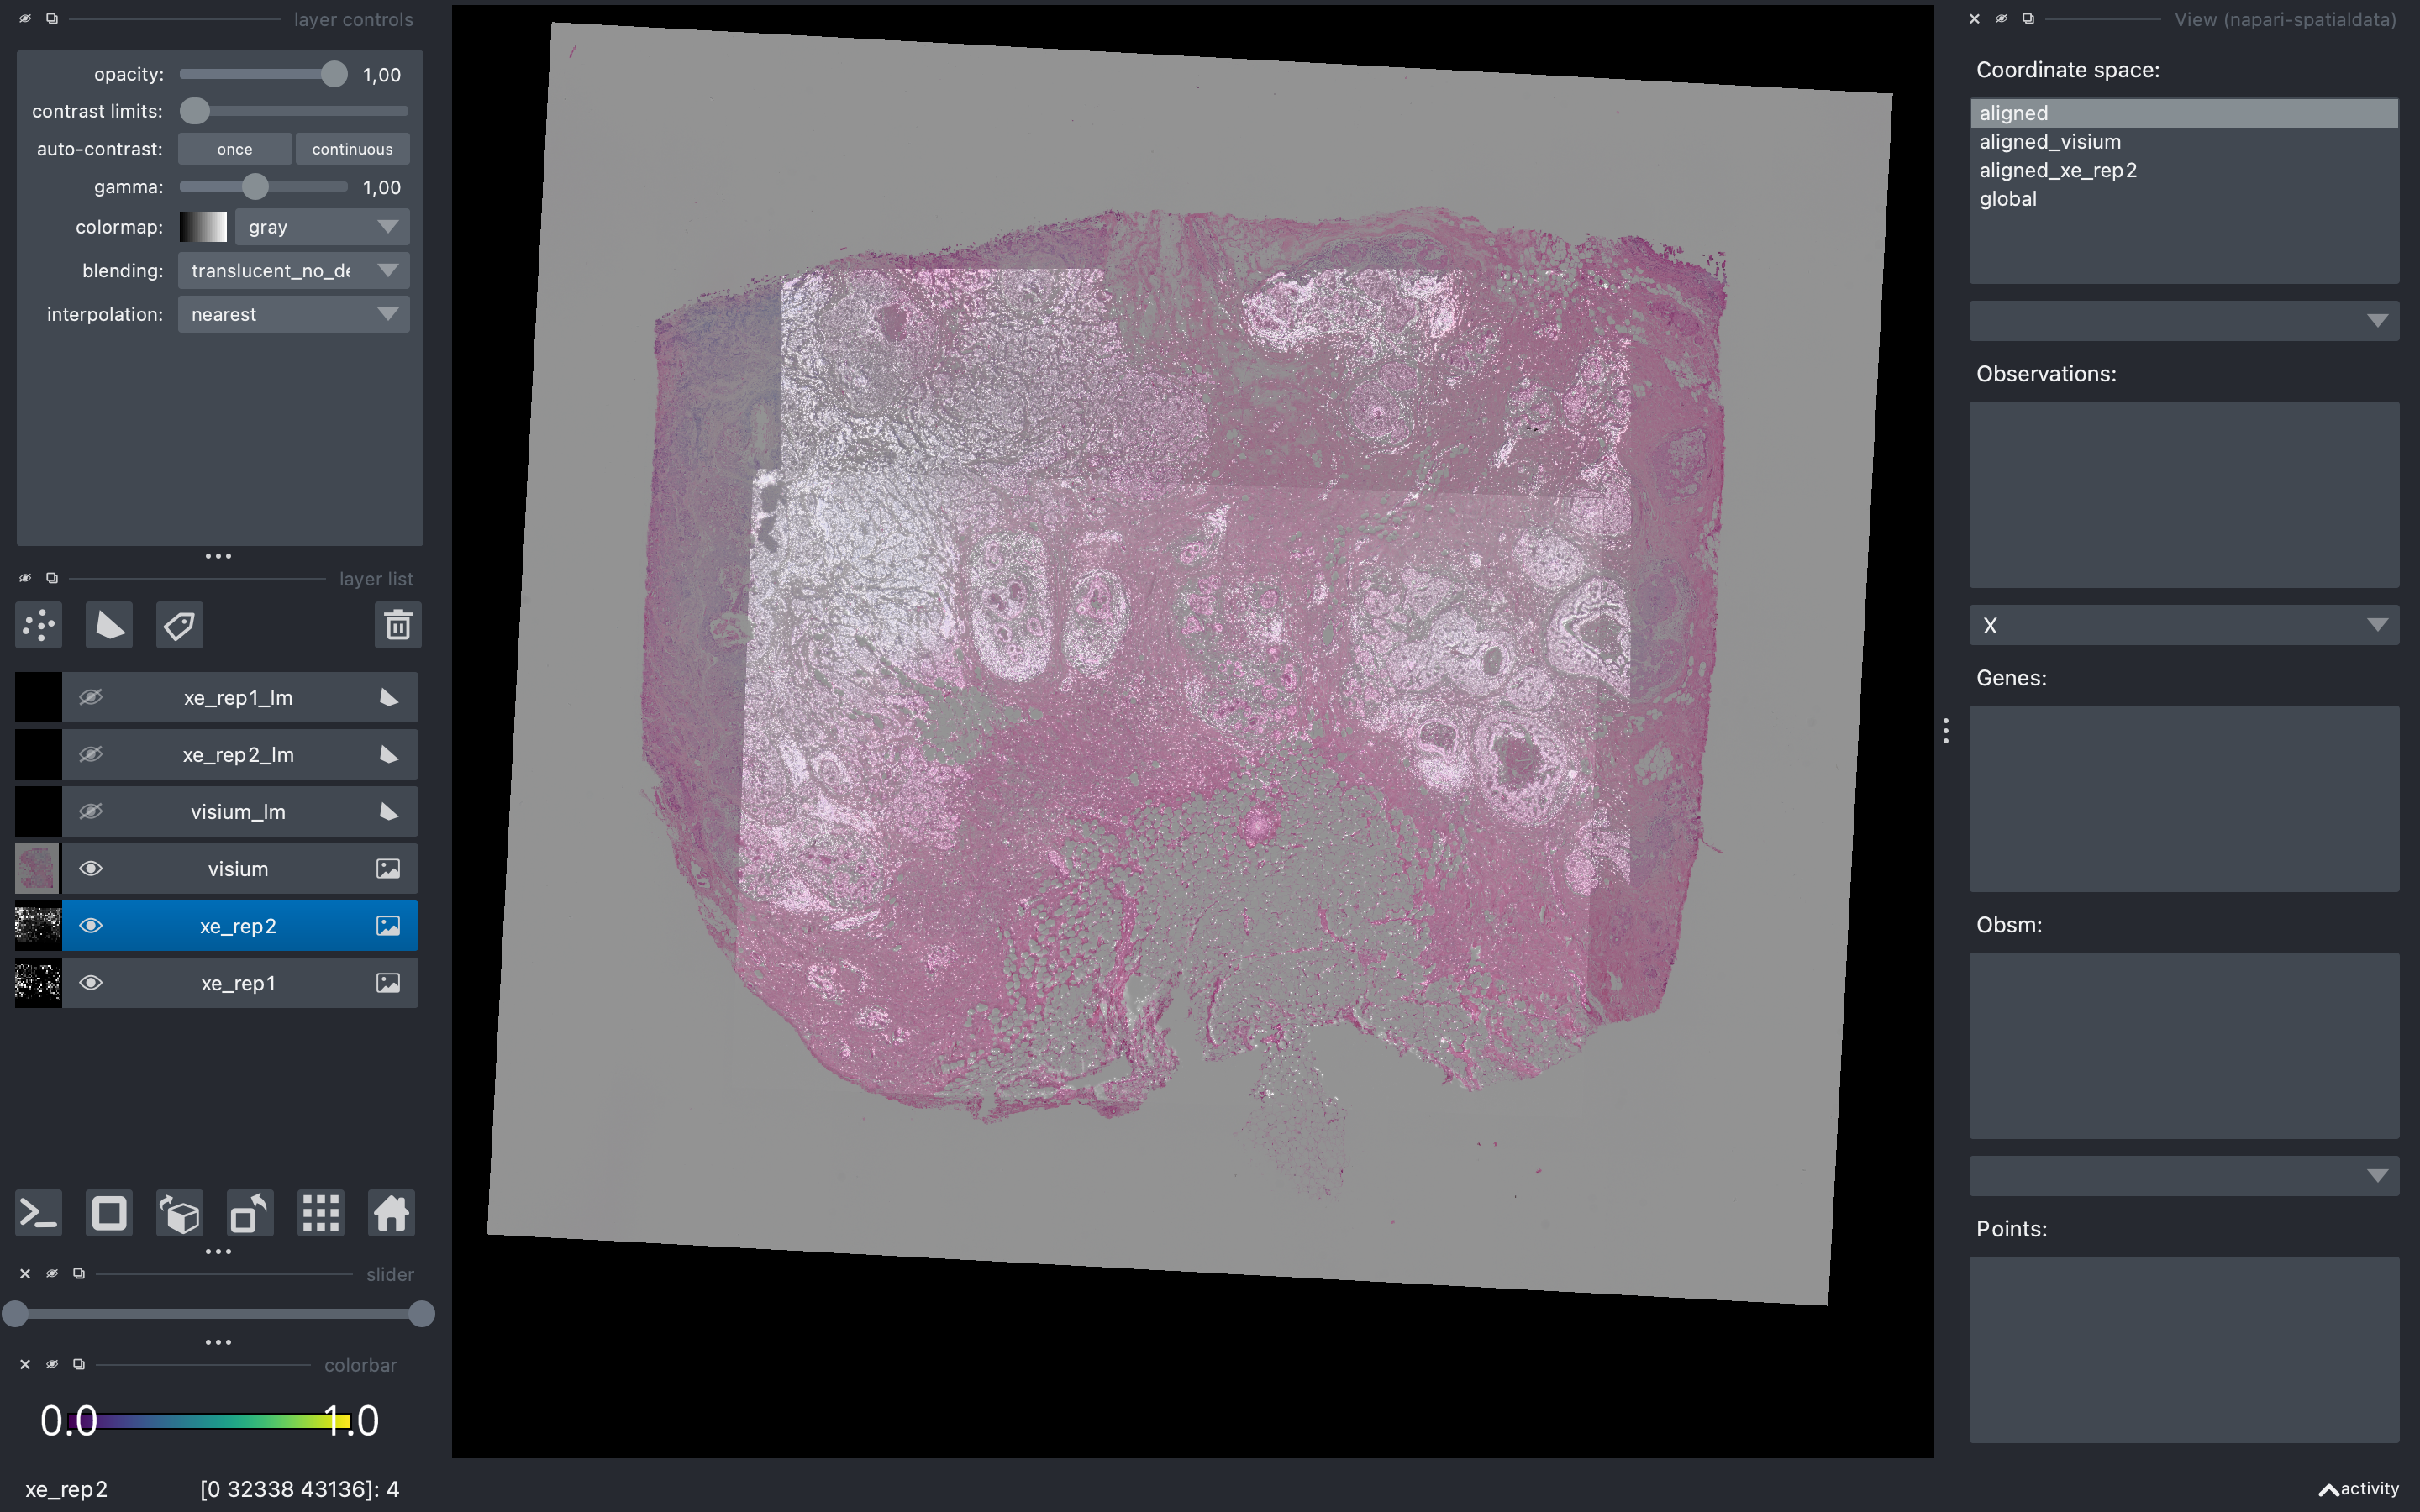

In [ ]:
set_transformation(xenium_subset.images['xe_rep1'], xe_rep1_alignment, 'aligned')
set_transformation(xenium_subset.images['xe_rep2'], xe_rep2_alignment, 'aligned')
set_transformation(xenium_subset.images['visium'], visium_alignment, 'aligned')

In [ ]:
bb = get_transformation(xenium_subset.images['xe_rep2'], 'aligned')

In [ ]:
# t = get_transformation(xenium_subset.images['xe_rep2'], 'aligned')
from spatialdata._core.core_utils import get_default_coordinate_system
from spatialdata._core.transformations import Affine, Sequence, Identity
from spatialdata._core._transform_elements import align_elements_using_landmarks
from spatialdata._core._spatialdata_ops import get_transformation, set_transformation
xe_rep2_box = xe_rep2_alignment.transform(box)

In [ ]:
xe_rep2_box = xe_rep2_alignment.transform(box)

In [ ]:
landmarks_sdata.shapes['box'] = box
landmarks_sdata.write(LANDMARKS_SDATA_PATH, overwrite=False)

In [9]:
LANDMARKS_SDATA_PATH = os.path.join(ZARR_DATA_PATH, "sandbox.zarr")

NameError: name 'ZARR_DATA_PATH' is not defined

In [ ]:
xe_rep2_box.bounds

In [ ]:
new_cells = xe_rep2_alignment.transform(xe_rep2_sdata.shapes['cell_boundaries'])

In [ ]:
xe_rep1_sdata.shapes['nucleus_boundaries']

In [ ]:
from shapely.validation import make_valid
gdf = xe_rep1_sdata.shapes['nucleus_boundaries']
bbb = gdf.apply(lambda row : make_valid(row.geometry), axis=1)
xe_rep1_rect = bbb.unary_union.envelope

In [ ]:
gdf = new_cells
bbb = gdf.apply(lambda row : make_valid(row.geometry), axis=1)
xe_rep2_rect = bbb.unary_union

In [ ]:
xe_rep2_rect = bbb.unary_union

In [ ]:
xe_rep2_rect

In [ ]:
intt = xe_rep1_rect.intersection(xe_rep2_rect)

In [ ]:
print(xe_rep2_rect)

In [ ]:
xe_rep1_sdata.shapes['nucleus_boundaries'].iloc[:10000].geometry.values.unary_union().envelope

In [ ]:
xe_rep1_sdata.shapes['cell_boundaries'].geometry.unary_union

In [ ]:
new_cells['geometry']

In [ ]:
xe_rep2_sdata.shapes['box'] = xe_rep2_box

In [ ]:
im = xe_rep2_alignment.transform(xenium_subset.images['xe_rep2'])

In [ ]:
Interactive(xe_rep2_sdata)

In [ ]:
from shapely.geometry import Polygon, LineString, Point, MultiPoint
s = geopandas.GeoSeries(
    [
        Polygon([(0, 0), (1, 1), (0, 1)]),
        LineString([(0, 0), (1, 1), (1, 0)]),
        MultiPoint([(0, 0), (1, 1), (0, 1), (1, 0), (0.5, 0.5)]),
        MultiPoint([(0, 0), (1, 1)]),
        Point(0, 0),
    ]
)
s.unary_union

In [ ]:
xe2_subset = xenium_subset = sd.SpatialData(
    images={
        "image": im
    },
    shapes={
        "box": xe_rep2_box
    }
    
)

In [ ]:
xe_rep1_sdata.shapes['cell_boundaries'].bounds['maxy'].max()

In [ ]:
scale_name = f"scale{2}"
dt = xenium_subset.images['xe_rep1'][scale_name]
v = dt.values()
assert len(v) == 1
xdata = next(iter(v))
t = xdata.attrs['transform']['global']

In [ ]:
t.inverse().transform(bb).bounds

In [ ]:
xe_rep1_sdata.shapes['cell_boundaries'].bounds['maxx'].max()

In [ ]:
Interactive(xe2_subset)

In [ ]:
xenium_subset.shapes['box'].bounds

In [ ]:
cells_2 = xe_rep2_alignment.transform(xe_rep2_sdata.shapes['cell_boundaries'])
cells_2.bounds['miny'].min()

In [ ]:
xe1_subset =  sd.SpatialData(
    images={
        "image": xenium_subset.images['xe_rep1']
    }
    
)

In [ ]:
xe1_subset.shapes['box2'].bounds

In [ ]:
xe1_subset.shapes['box'].bounds